Generating Regional Active Editors chart...


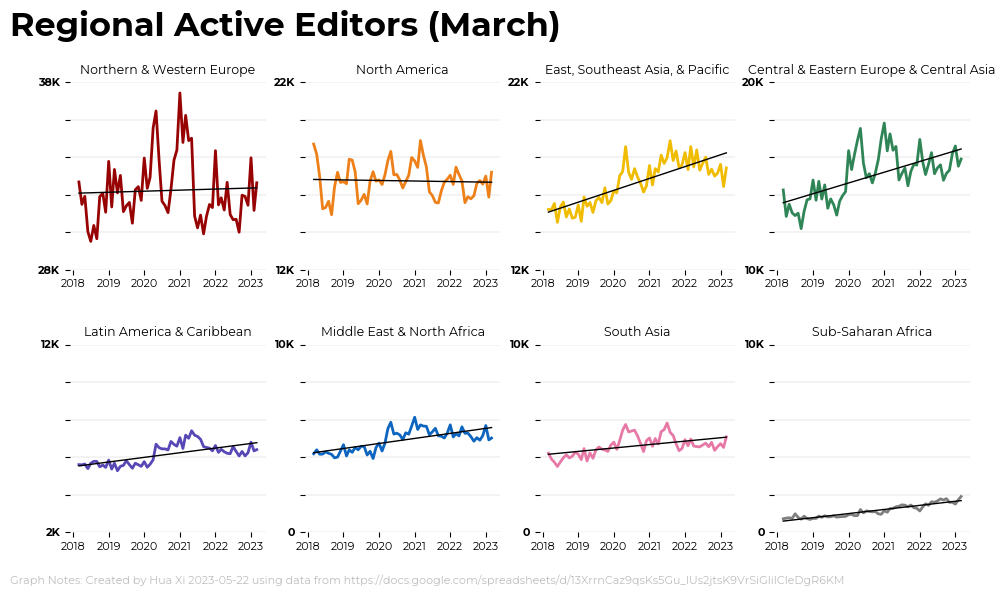

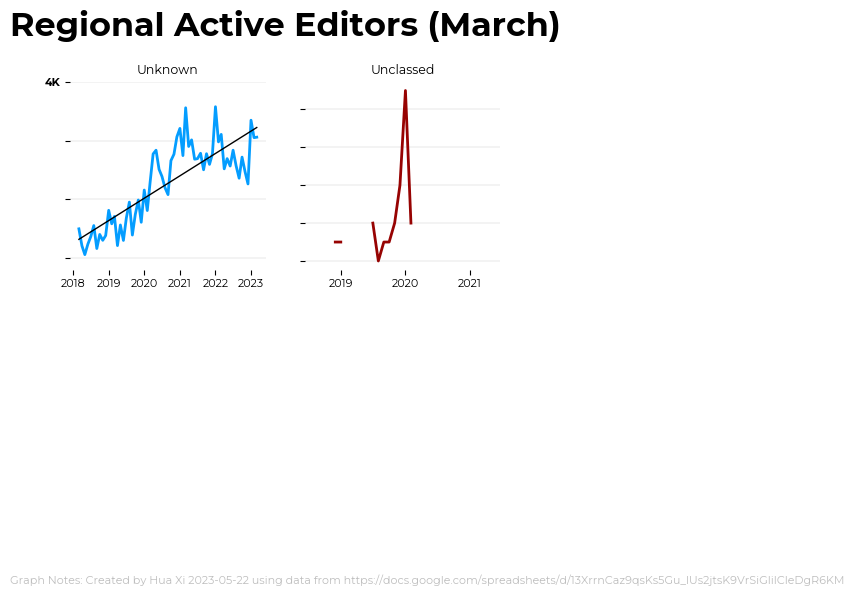

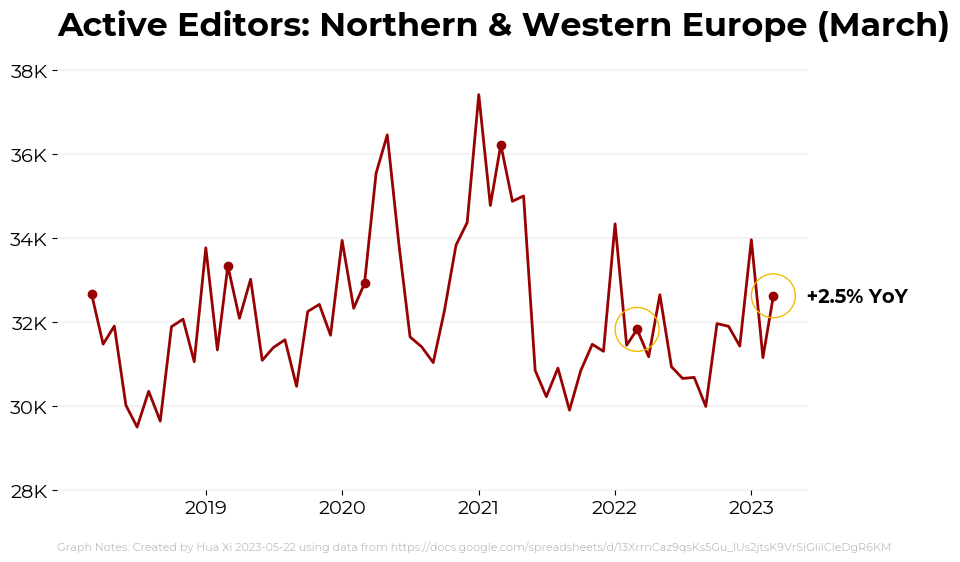

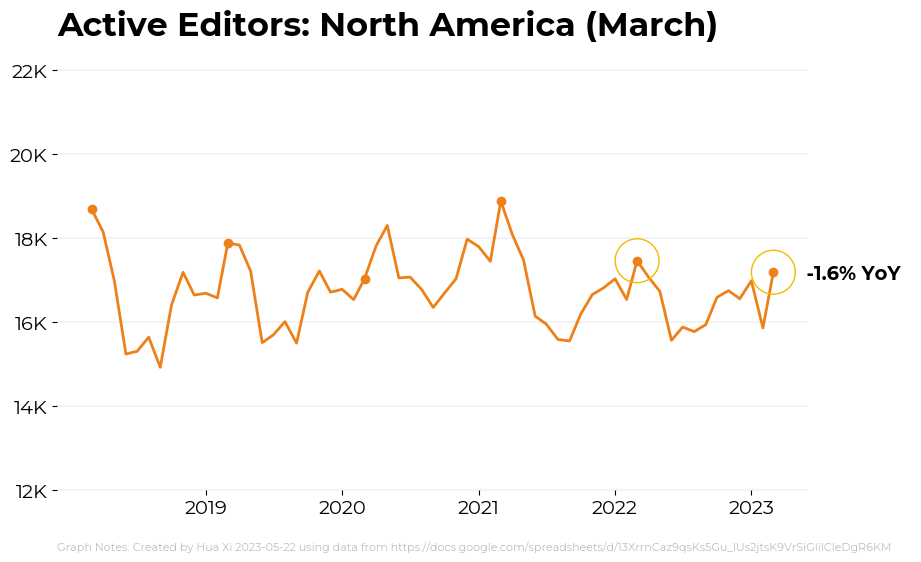

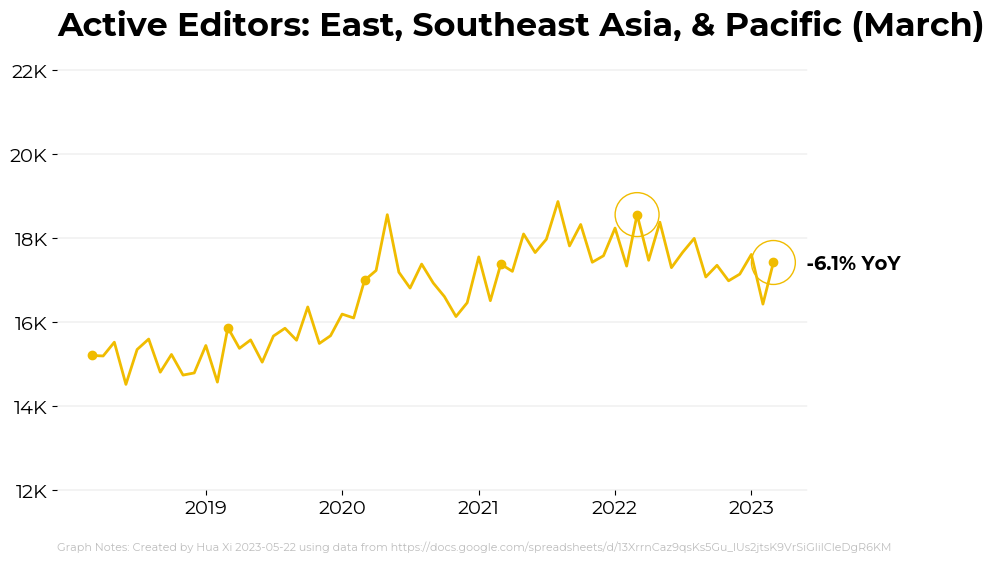

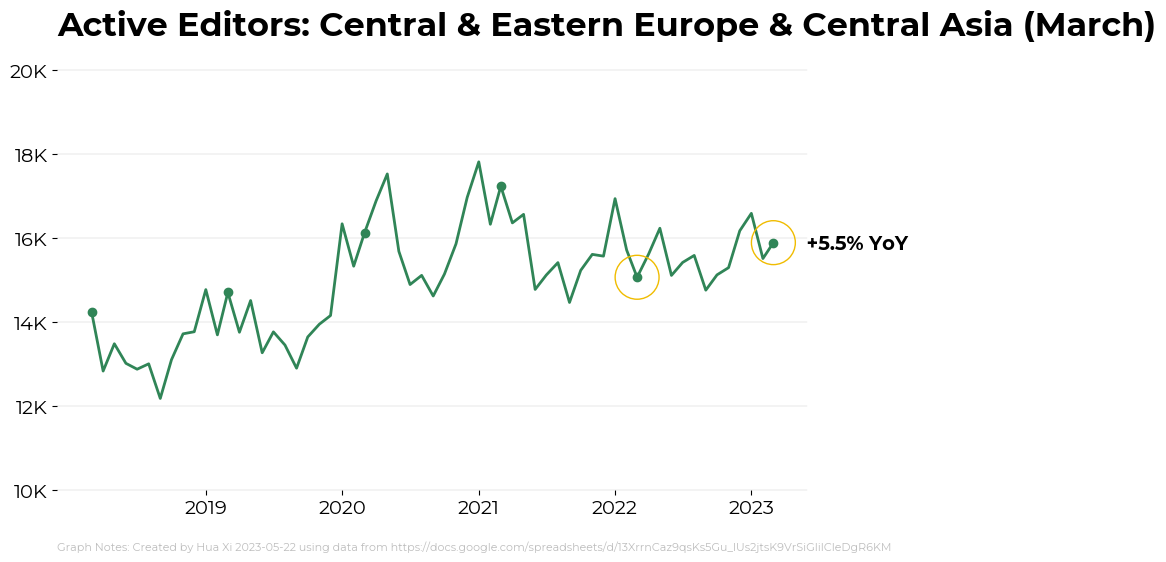

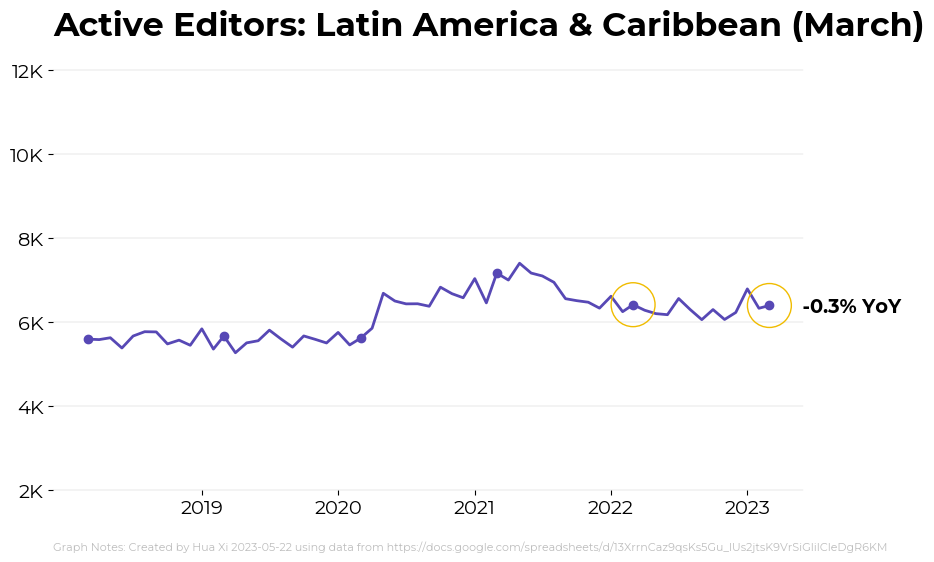

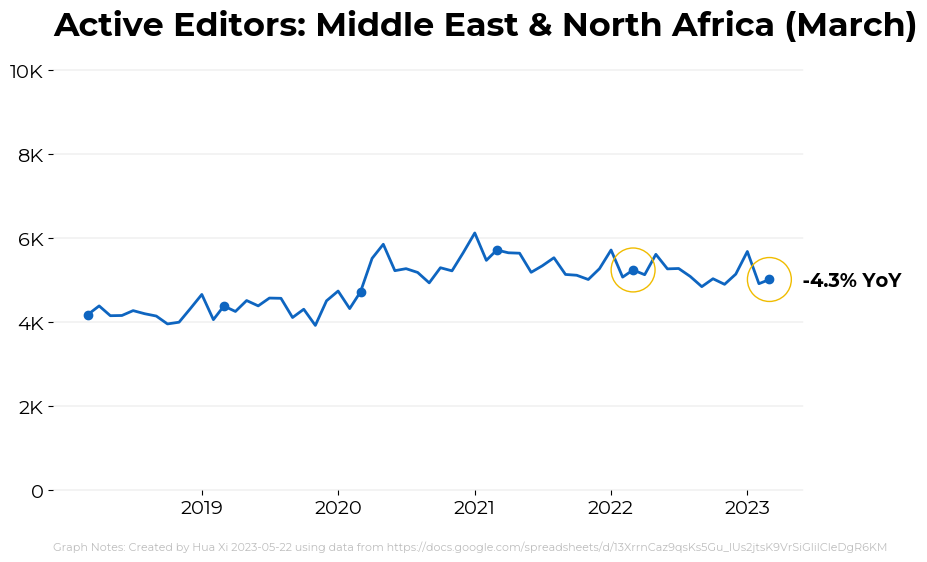

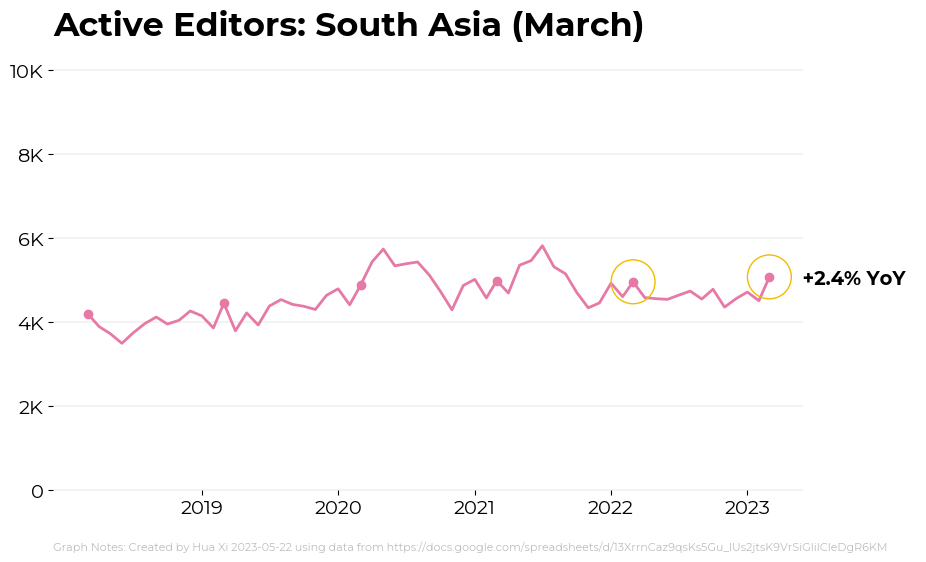

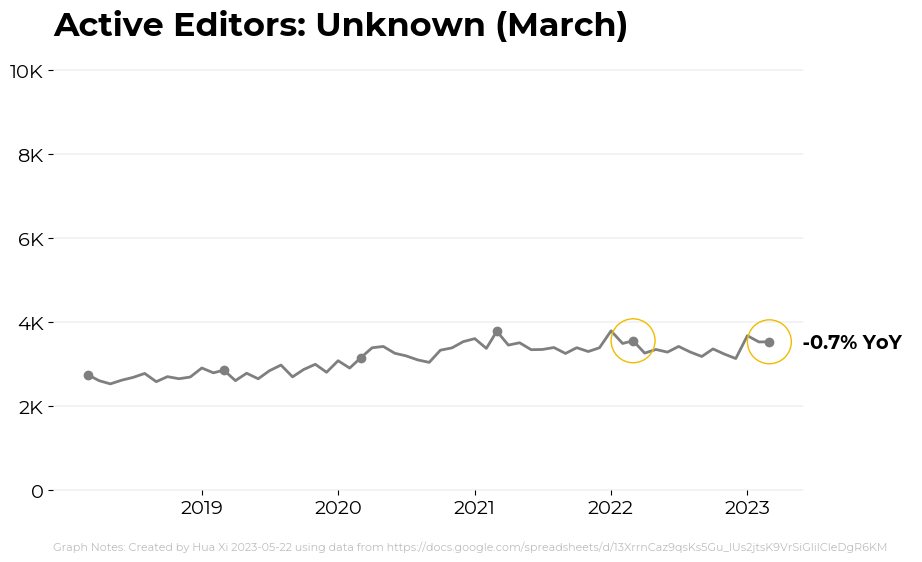

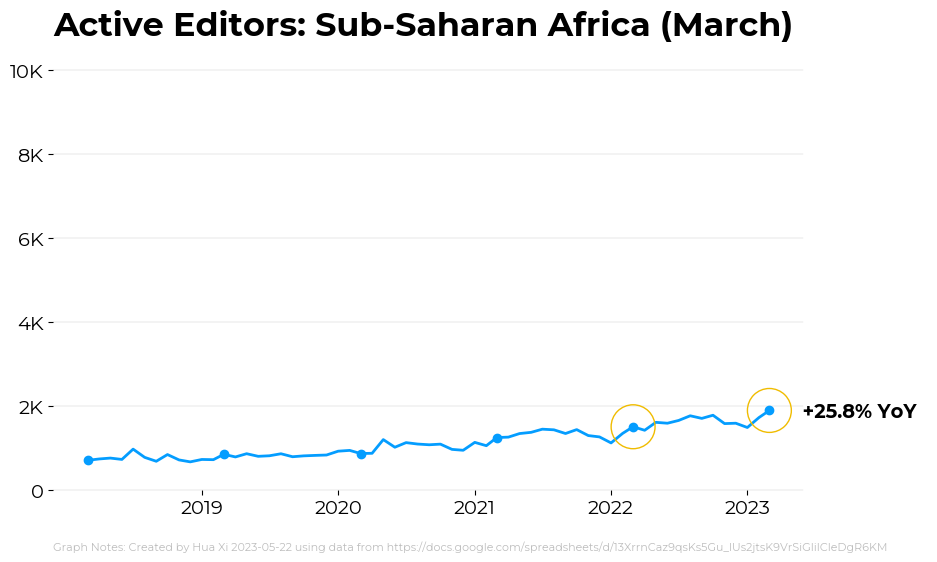

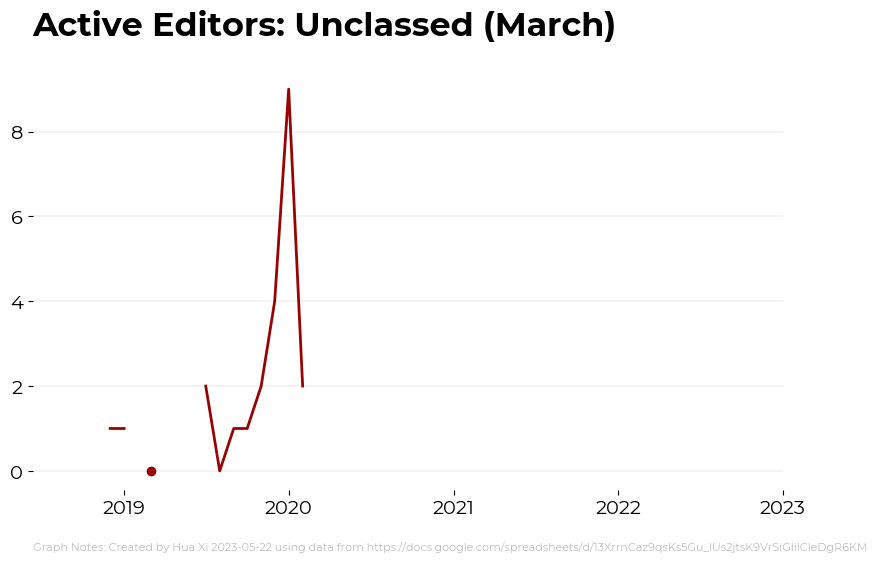

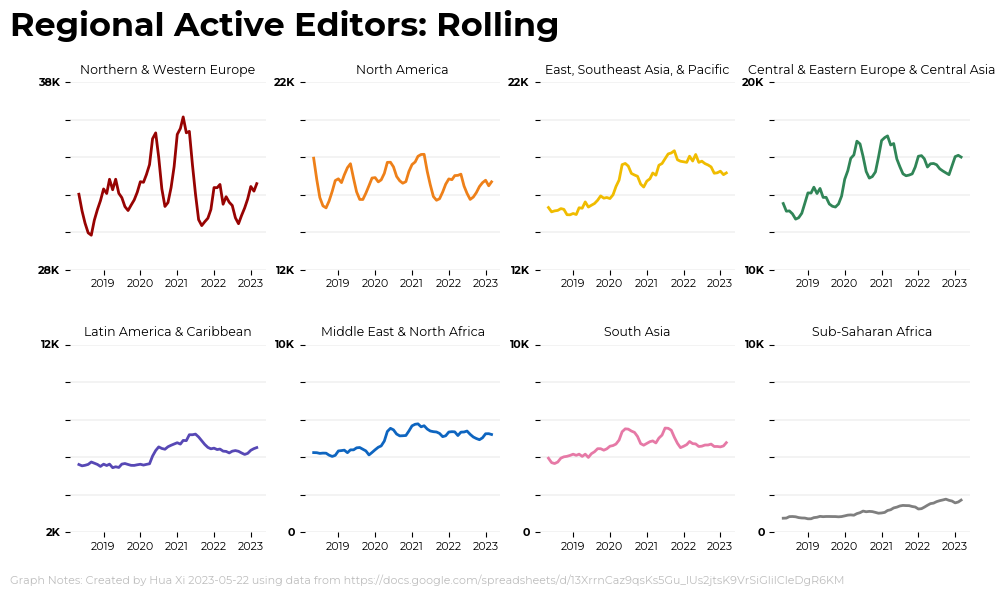

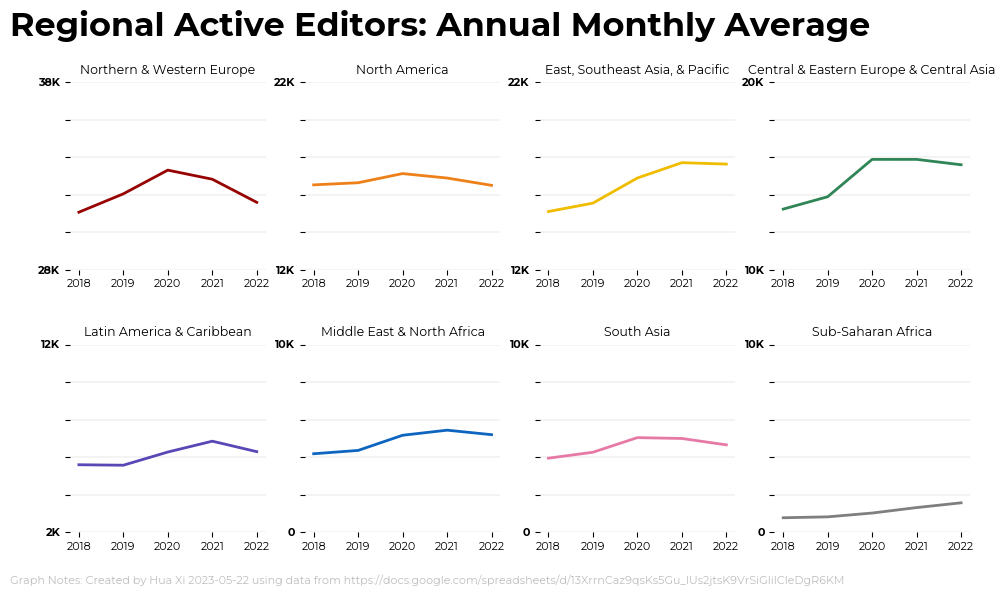

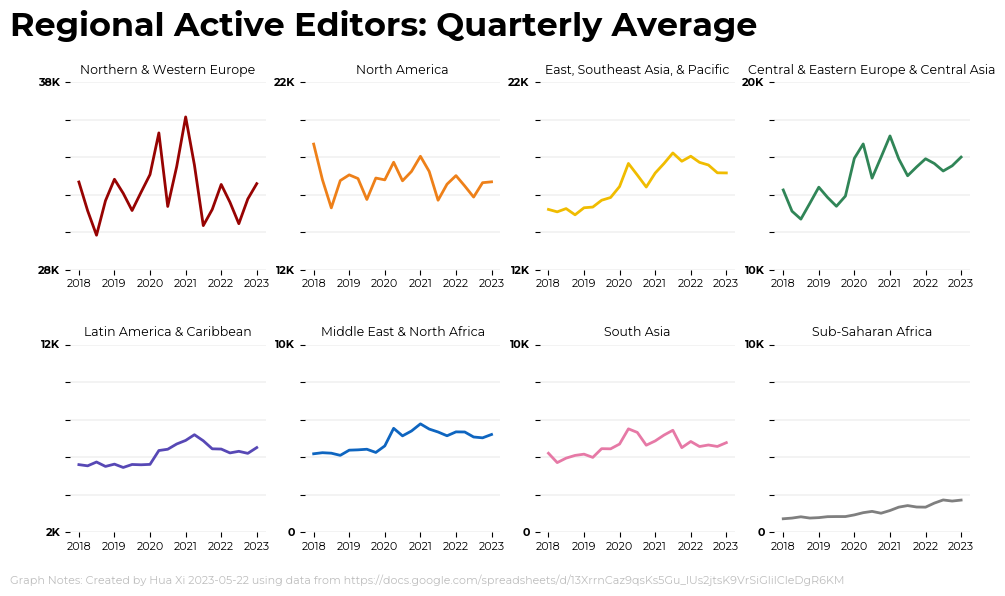

In [1]:
import pandas as pd
from datetime import date, datetime, timedelta
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import os
from os.path import dirname
import warnings
#local
#from wikicharts import Wikichart, wmf_colors, wmf_regions, split_df_by_col, gen_keys, roll
#jupyter notebook
%run wikicharts.ipynb

def main():
    print("Generating Regional Active Editors chart...")

    warnings.filterwarnings("ignore")

    #---PROMPT FOR INPUT---
    #current path
    home_dir = os.getcwd()
    #py file only (comment out next line in jupyter notebook)
    #home_dir = dirname(home_dir)
    #where file is saved
    outfile_name = "Regional_Active_Editors"
    save_file_name = home_dir + "/charts/" + outfile_name
    #note for labeling the YoY highlight
    yoy_note = " "
    #display or note
    display_flag = True

    #---CLEAN DATA--
    #Data Columns: "month", "sum(editors)", wmf_region"
    df = pd.read_csv(home_dir + '/resources/data/regional_editor_metrics.csv')
    #note start and end dates may be different depending on chart_type
    start_date = "2018-03-01"
    end_date = datetime.today()
    #convert string to datetime
    df['month'] = pd.to_datetime(df['month'])
    #truncate data to period of interst
    df = df[df["month"].isin(pd.date_range(start_date, end_date))]
    #fill in NaNs with blanks
    df = df.fillna('')
    #pivot to make regions separate columns
    df = df.rename(columns={'sum(editors)':"monthly_editors"})
    df = df.pivot(index='month', columns='wmf_region', values='monthly_editors').reset_index()
    #rename unknown and unclassed
    df = df.rename(columns={np.nan: "Unknown",'': "Unknown",'UNCLASSED':"Unclassed"})
    #sort columns by total
    #add a Totals row at bottom
    df.loc['Total'] = df.iloc[:, :-1].sum()
    #sort columns left to right for highest to lowest totals
    df = df.sort_values('Total', axis=1, ascending=False)
    #print Totals row (sorted)
    #delete Totals row
    df = df.iloc[:-1]
    #create different dfs for each figure
    max_charts_per_figure = 8
    #split into a dataframe with 8 regions, and another one with the Unknown and Unclassed columns
    df = df.set_index('month')
    dfs = [df[wmf_regions].reset_index(), df[df.columns[~df.columns.isin(wmf_regions)]].reset_index()]
    df = df.reset_index()
    #generate keys that correspond each region to a diff color
    key_colors = [wmf_colors['red'], wmf_colors['orange'], wmf_colors['yellow'], wmf_colors['green'], wmf_colors['purple'], wmf_colors['blue'], wmf_colors['pink'], wmf_colors['black50'], wmf_colors['brightblue']]
    keys = gen_keys(dfs, key_colors)

    #---MAKE CHARTS---
    fig_counter = 0
    total_num_charts = len(df.columns) - 1
    num_figures = ceil(total_num_charts / max_charts_per_figure)
    figures = [None]*num_figures
    #max range across figures
    maxranges = [None]*num_figures
    num_ticks = [None]*num_figures
    #initialize each figure
    for f in range(num_figures):
        fig_counter += 1
        charts_in_figure = len(dfs[f].columns) - 1
        figures[f] = Wikichart(start_date,end_date,dfs[f])
        figures[f].init_plot(width=12,subplotsx=2,subplotsy=4,fignum=f)
        figures[f].plot_subplots_lines('month', keys[f], num_charts=charts_in_figure, subplot_title_size=9)
        figures[f].plot_multi_trendlines('month', keys[f], num_charts=charts_in_figure)
        maxranges[f], num_ticks[f] = figures[f].get_maxyrange()
        figures[f].standardize_subplotyrange(maxranges[f], num_ticks[f], num_charts=charts_in_figure)
        figures[f].format_subplots(title = 'Regional Active Editors',
            key = keys[f],
            data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
            num_charts=charts_in_figure,
            tickfontsize=8)
        figures[f].clean_ylabels_subplots(tickfontsize=8)
        #save chart but set display to False because plt.show() will show all figures at once
        save_file_name = home_dir + "/charts/" + outfile_name + "_" + str(f) + ".jpeg"
        figures[f].finalize_plot(save_file_name,display=False)
    maxrange = maxranges[0]
    maxrange_numticks = num_ticks[0]

    #---GENERATE INDIVIDUAL CHARTS---
    #creates individual full-sized charts for each region
    individual_charts = [None]*total_num_charts
    columns = list(df.columns)
    columns.remove('month')
    for c in range(len(columns)):
        fig_counter = fig_counter + 1
        current_col = columns[c]
        current_df = df[['month', current_col]]
        current_savefile = home_dir + "/charts/individual_" + outfile_name + "_" + str(c) + ".jpeg"
        individual_charts[c] = Wikichart(start_date,end_date,current_df)
        individual_charts[c].init_plot(fignum=fig_counter)
        #cycle through key colors
        current_color = key_colors[(c % len(key_colors))]
        individual_charts[c].plot_line('month',current_col,col=current_color)
        individual_charts[c].plot_monthlyscatter('month',current_col,col=current_color)
        individual_charts[c].plot_yoy_highlight('month',current_col)
        individual_charts[c].standardize_yrange(maxrange, maxrange_numticks)
        individual_charts[c].format(title = f'Active Editors: {current_col}',
            ybuffer=False,
            data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
            tadjust=0.825,badjust=0.125,
            titlepad=25)
        individual_charts[c].annotate(x='month',
            y=current_col,
            num_annotation=individual_charts[c].calc_yoy(y=current_col,yoy_note=yoy_note))
        individual_charts[c].finalize_plot(current_savefile,display=False)

    #---AGGREGATE VIEWS---
    #Rolling View
    core_df = dfs[0] #without Unknown and Unclassed
    charts_in_figure = len(core_df.columns)
    rolling = roll(core_df, rolling_months = 3)
    fig_counter += 1
    main_fig = Wikichart(start_date,end_date,rolling)
    main_fig.init_plot(width=12,subplotsx=2,subplotsy=4,fignum=fig_counter)
    main_fig.plot_subplots_lines(x='month', key=keys[0], num_charts=charts_in_figure, subplot_title_size=9)
    main_fig.standardize_subplotyrange(maxrange, maxrange_numticks, num_charts=charts_in_figure)
    main_fig.format_subplots(title = 'Regional Active Editors: Rolling',
            key = keys[0],
            data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
            num_charts=charts_in_figure,
            tickfontsize=8,
            mo_in_title=False)
    main_fig.clean_ylabels_subplots(tickfontsize=8)
    save_file_name = home_dir + "/charts/" + outfile_name + "_rolling.png"
    main_fig.finalize_plot(save_file_name,display=False)
    #Annual Monthly Average
    core_df = dfs[0]
    charts_in_figure = len(core_df.columns)
    full_years = core_df[core_df["month"].isin(pd.date_range(start_date, '2022-12-31'))]
    annual = full_years.groupby(core_df.month.dt.year).mean().reset_index()
    annual['month'] = pd.to_datetime(annual['month'], format='%Y')
    fig_counter += 1
    main_fig = Wikichart(start_date,end_date,annual, set_month_interest=False)
    main_fig.init_plot(width=12,subplotsx=2,subplotsy=4,fignum=fig_counter)
    main_fig.plot_subplots_lines(x='month', key=keys[0], num_charts=charts_in_figure, subplot_title_size=9)
    main_fig.standardize_subplotyrange(maxrange, maxrange_numticks, num_charts=charts_in_figure)
    main_fig.format_subplots(title = 'Regional Active Editors: Annual Monthly Average',
            key = keys[0],
            data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
            num_charts=charts_in_figure,
            tickfontsize=8,
            mo_in_title=False)
    main_fig.clean_ylabels_subplots(tickfontsize=8)
    save_file_name = home_dir + "/charts/" + outfile_name + "_annual.png"
    main_fig.finalize_plot(save_file_name,display=False)
    #Quarterly
    core_df = dfs[0]
    charts_in_figure = len(core_df.columns)
    quarterly = core_df.groupby(core_df['month'].dt.to_period('Q')).mean().reset_index()
    quarterly['month'] = quarterly['month'].astype(str)
    quarterly['month'] = pd.to_datetime(quarterly['month'])
    fig_counter += 1
    main_fig = Wikichart(start_date,end_date,quarterly, set_month_interest=False)
    main_fig.init_plot(width=12,subplotsx=2,subplotsy=4,fignum=fig_counter)
    main_fig.plot_subplots_lines(x='month', key=keys[0], num_charts=charts_in_figure, subplot_title_size=9)
    main_fig.standardize_subplotyrange(maxrange, maxrange_numticks, num_charts=charts_in_figure)
    main_fig.format_subplots(title = 'Regional Active Editors: Quarterly Average',
            key = keys[0],
            data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
            num_charts=charts_in_figure,
            tickfontsize=8,
            mo_in_title=False)
    main_fig.clean_ylabels_subplots(tickfontsize=8)
    save_file_name = home_dir + "/charts/" + outfile_name + "_quarterly.png"
    main_fig.finalize_plot(save_file_name,display=False)

if __name__ == "__main__":
    main()
